In [2]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck, drop
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
)
from scipy.spatial.distance import pdist, squareform

In [3]:
def make_sex_age_plot(age_df, width, height):
    age_df = age_df.copy()
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    age_df['floored_age'] = (age_df['true_ages'] * 7) // 7
    ax = sns.lineplot(
        data=age_df,
        x="floored_age",
        y="bio_ages",
        hue="labels",
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        legend=False,
        zorder=-1,
        lw=0.25,
        err_kws=dict(lw=0),
    )
    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=2.5,
        lw=0,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (weeks)",
        aspect="equal",
        xlim=(0, 60),
    )
    sns.despine()
    return fig

def make_id_plot(age_df, width, height, hue_order=None, include_lines=False, ax_kwargs={}):
    age_df = age_df.copy()
    # age_df['floored_age'] = ((age_df['true_ages'] * 7) // 14) * 2

    min_label = age_df['labels'].min()
    age_df['labels'] = age_df['labels'] - min_label
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    fig = figure(width, height)
    ax = fig.gca()
    if hue_order is None:
        pal = cc.glasbey[min_label: age_df["labels"].max() + 1 + min_label]
    else:
        pal = [cc.glasbey[hue] for hue in hue_order]
    if include_lines:
        ax = sns.lineplot(
            data=age_df,
            x="true_ages",
            y="bio_ages",
            hue="labels",
            palette=pal,
            hue_order=hue_order,
            legend=False,
            zorder=-1,
            lw=0.25, err_kws=dict(lw=0), ax=ax
        )
    if hue_order is not None:
        age_df = age_df[age_df['labels'].isin(hue_order)]
    im = ax.scatter(
        age_df["true_ages"],
        age_df["bio_ages"],
        c=age_df["labels"],
        cmap=cc.cm.glasbey,
        vmin=0 - min_label,
        vmax=256 - min_label,
        s=4,
        lw=0,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Mouse ID",
    )
    cb.set_ticks(range(0, age_df['labels'].nunique() + 1, 3))
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (weeks)",
        aspect="equal",
        ylim=(0, 80),
        # xlim=(0, 70),
        **ax_kwargs
    )
    sns.despine()
    return fig

In [4]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "fig4-longv2-bambi", tight_layout=False)

In [5]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

In [6]:
def load_male_long_df():
    keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_counts_matrix_v00.parquet"
    )
    size_df = pd.read_parquet(
        '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_mouse_area_df_v00.parquet'
    )

    df = df[keep_syllables]
    df = df.join(size_df[['quant_0.5']])

    idx_names = df.index.names
    age = df.index.get_level_values('age')

    bins = pd.cut(age, 92, labels=False)

    sample = df.reset_index().groupby(['mouse', bins], observed=True).first().droplevel(1)
    sample = sample.reset_index().set_index(idx_names)

    age_cut = pd.cut(sample.index.get_level_values('age'), 11)

    sample['quant_0.5'] = zscore(sample.groupby(age_cut, observed=True)['quant_0.5'].transform(demean))

    return sample


def load_female_long_df():
    keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_counts_matrix_v00.parquet"
    )
    size_df = pd.read_parquet(
        '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_mouse_area_df_v00.parquet'
    )

    df = df[keep_syllables]
    df = df.join(size_df[['quant_0.5']])

    idx_names = df.index.names
    age = df.index.get_level_values('age')

    bins = pd.cut(age, 92, labels=False)

    sample = df.reset_index().groupby(['mouse', bins], observed=True).first().droplevel(1)
    sample = sample.reset_index().set_index(idx_names)

    age_cut = pd.cut(sample.index.get_level_values('age'), 11)

    sample['quant_0.5'] = zscore(sample.groupby(age_cut, observed=True)['quant_0.5'].transform(demean))

    return sample

In [7]:
m_df = load_male_long_df()
m_size_col = m_df['quant_0.5']
m_df = m_df.drop(columns=['quant_0.5'])

f_df = load_female_long_df()
f_size_col = f_df['quant_0.5']
f_df = f_df.drop(columns=['quant_0.5'])

df = pd.concat([m_df, f_df])
size_col = pd.concat([m_size_col, f_size_col])
sort_idx = np.argsort(df.to_numpy().sum(0))[::-1]

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(np.hstack([np.zeros(len(df) - len(f_df)), np.ones(len(f_df))])[:, None]).T

mouse_ids = label_encoder.fit_transform(df.index.get_level_values("mouse").to_numpy()[:, None]).T

mouse_cat = label_encoder.categories_[0]

syllable_counts_jax = jnp.array(df.astype('float32'))
age = jnp.array(df.index.get_level_values('age'))
assert size_col.isna().sum() == 0, "issue with NaNs in size data"

In [8]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "sex": sex_id,
    "mice": mouse_ids,
}

age_sd = 0.03

hypparams = {
    "log_age": True,
    "min_age": 1,
    "max_age": 130,
    "age_sd": age_sd,
    "n_age_samples": 1500,
    "n_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 5,
    "n_sex_splines": 5,
    "scale": 400,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "n_sexes": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 500,
}

## Test boundaries of data acquisition

In [8]:
label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)

m_df = load_male_long_df()
f_df = load_female_long_df()
df = pd.concat([m_df, f_df])
df['sex'] = np.argmax(sex_id, axis=0)
df = df.set_index('sex', append=True)

In [9]:
max_age = np.arange(5, 51, 5)[::-1]

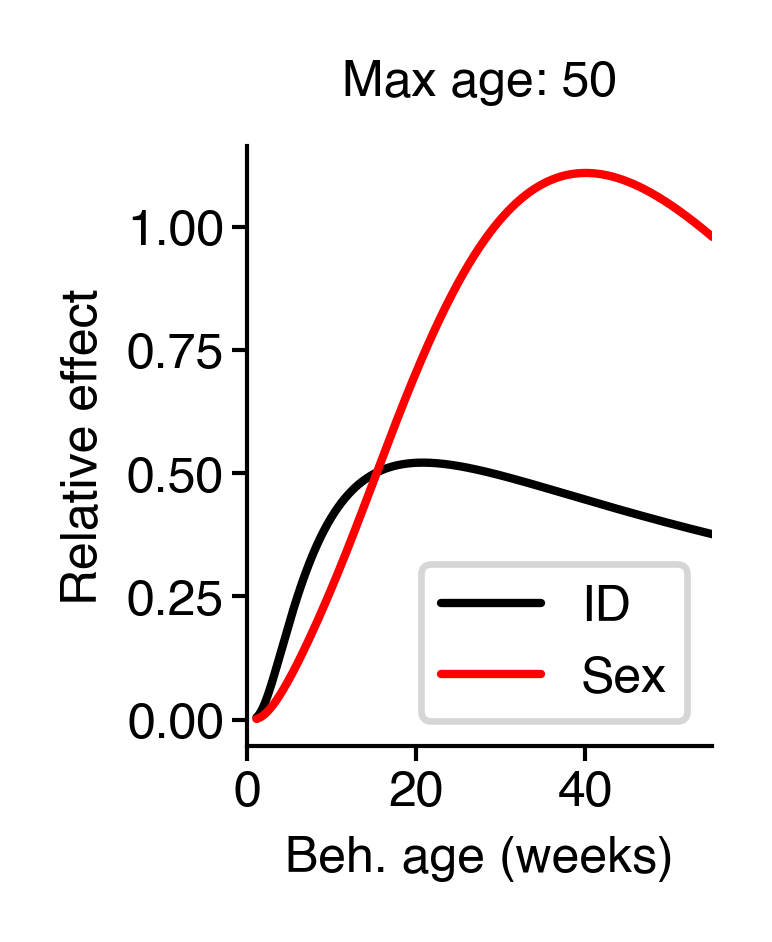

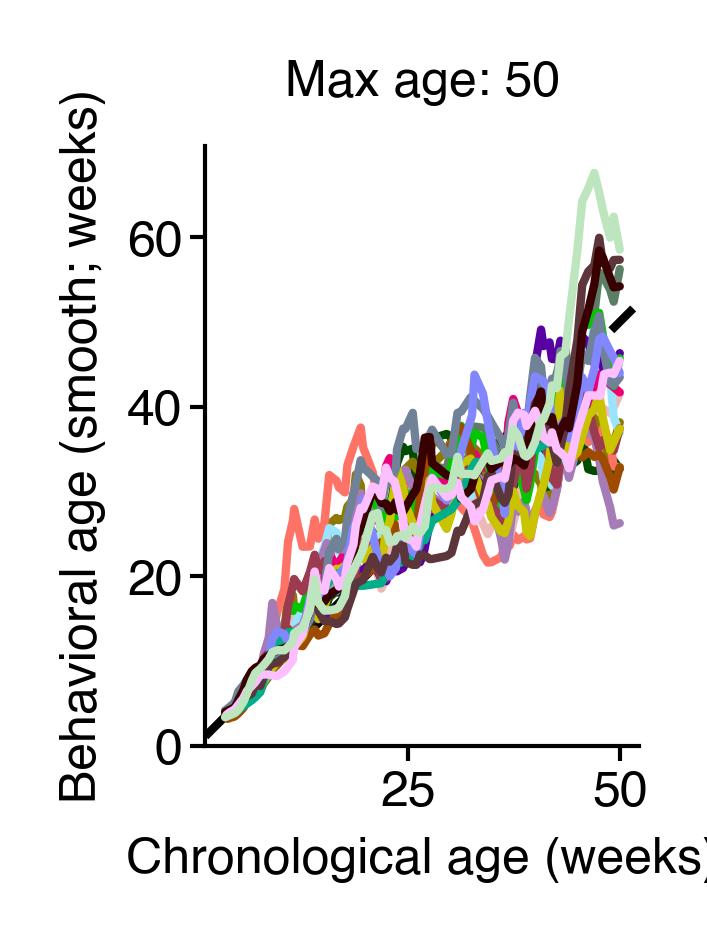

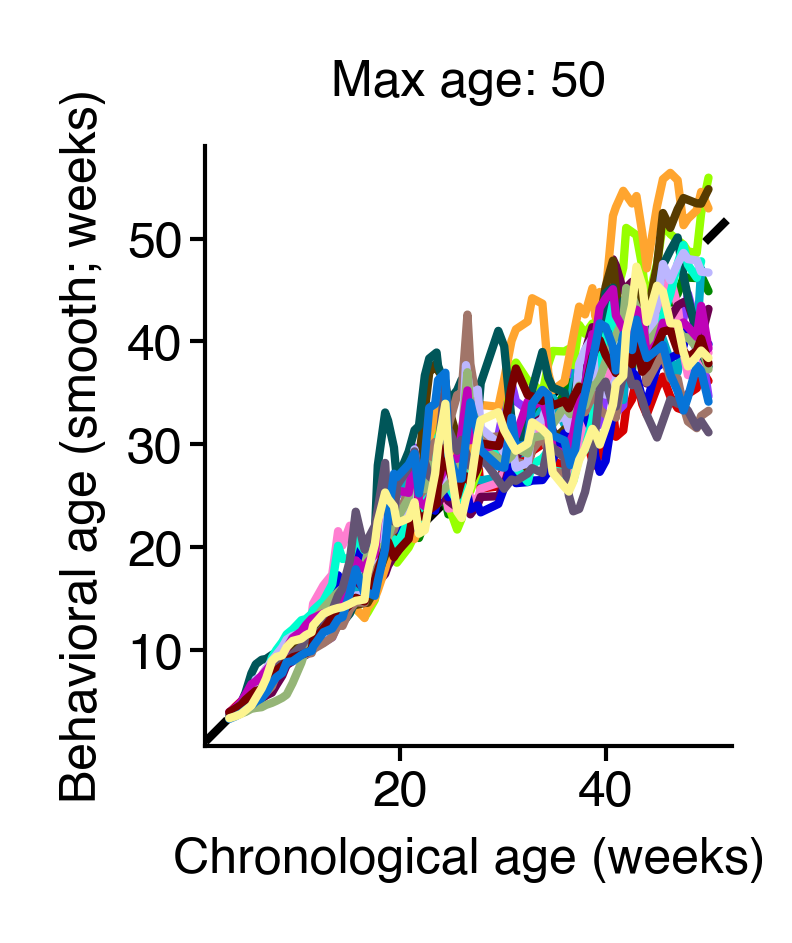

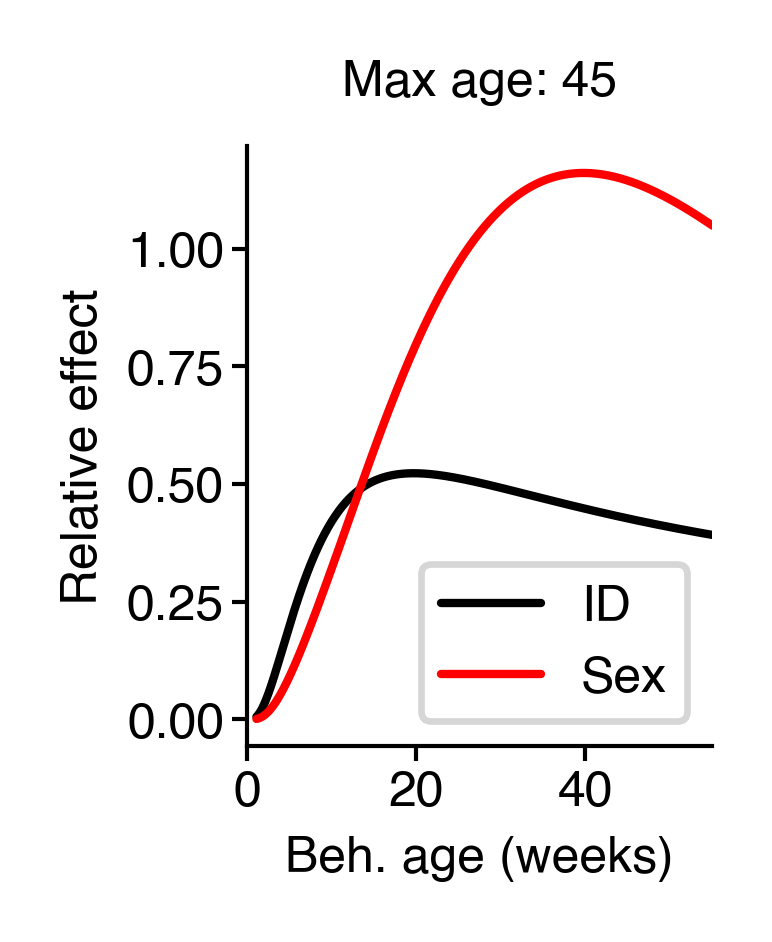

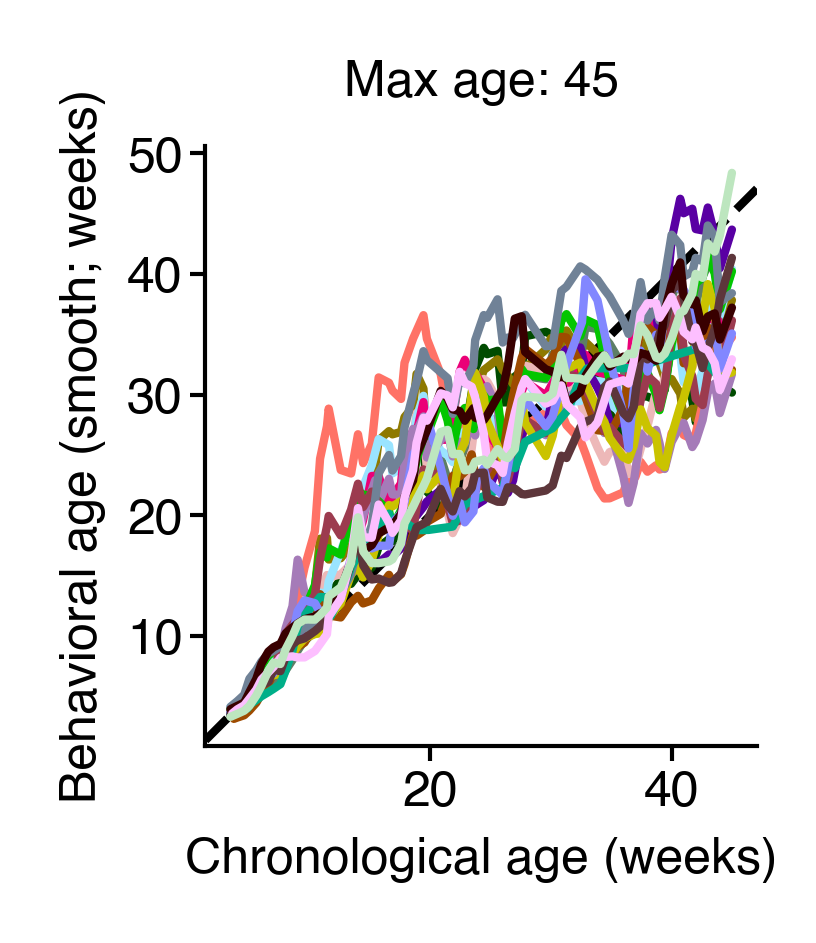

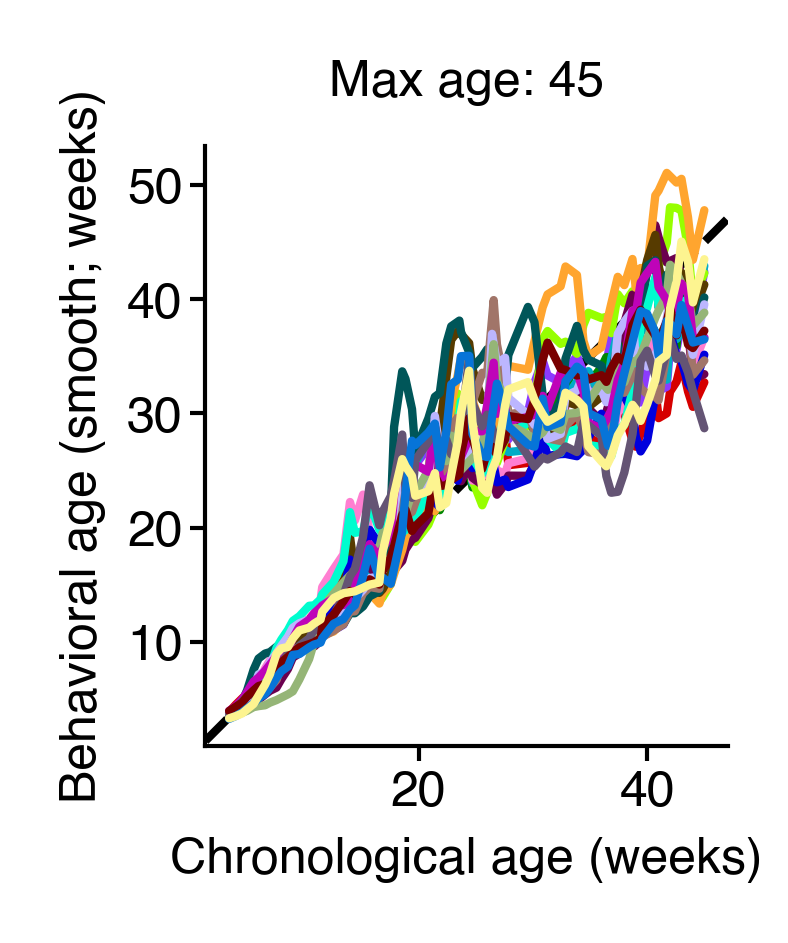

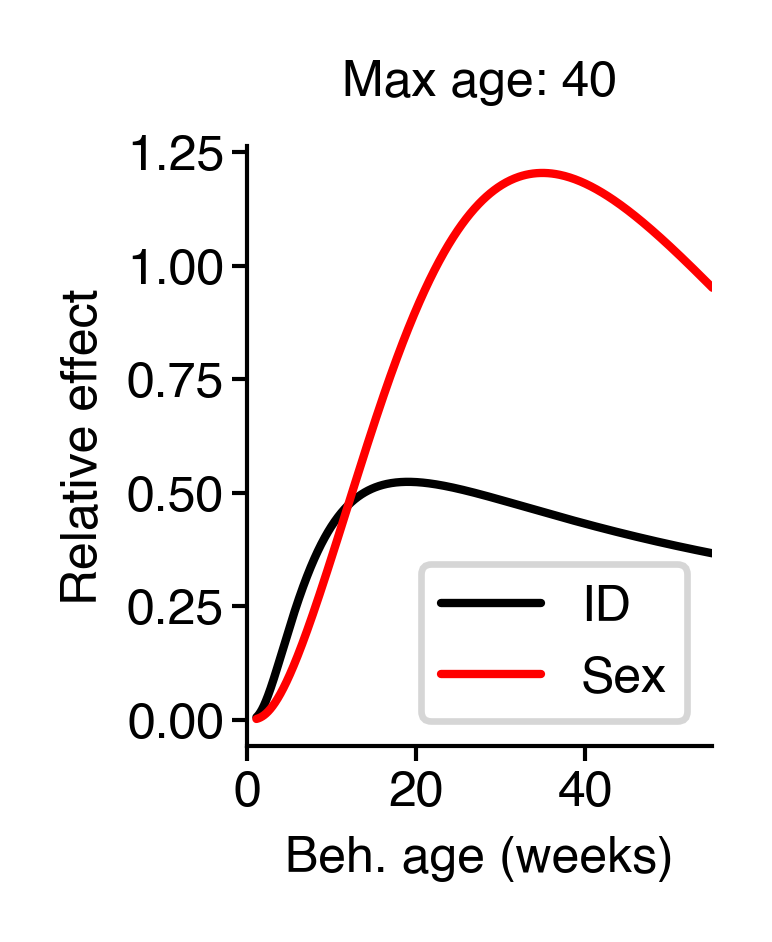

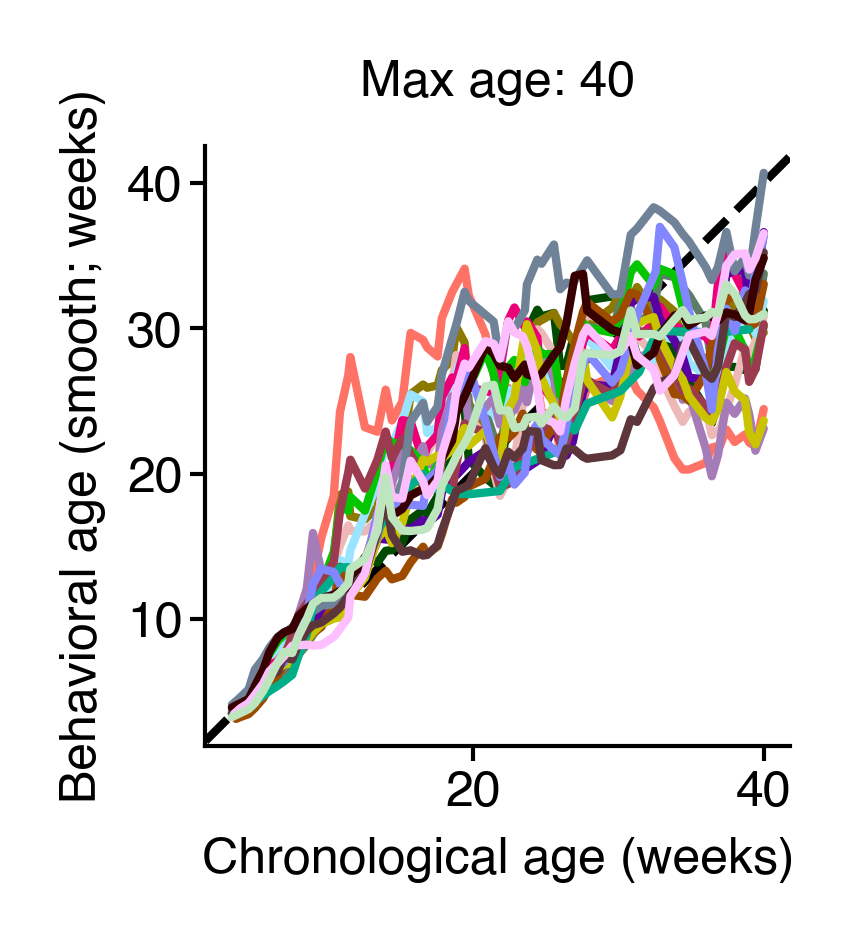

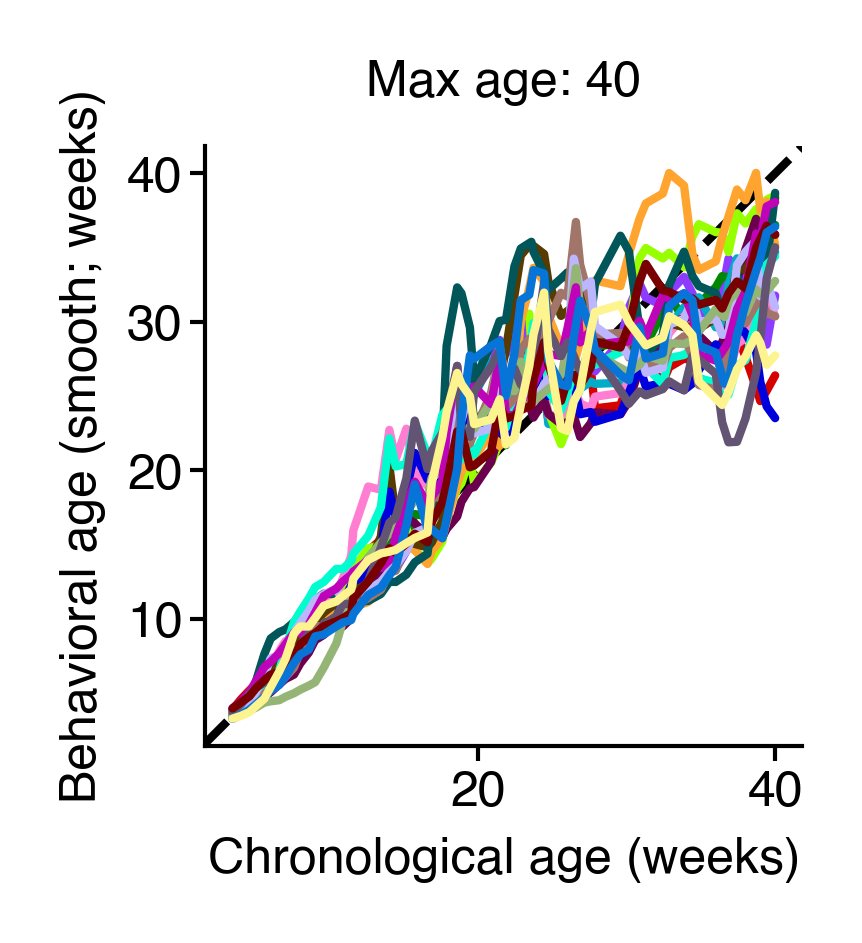

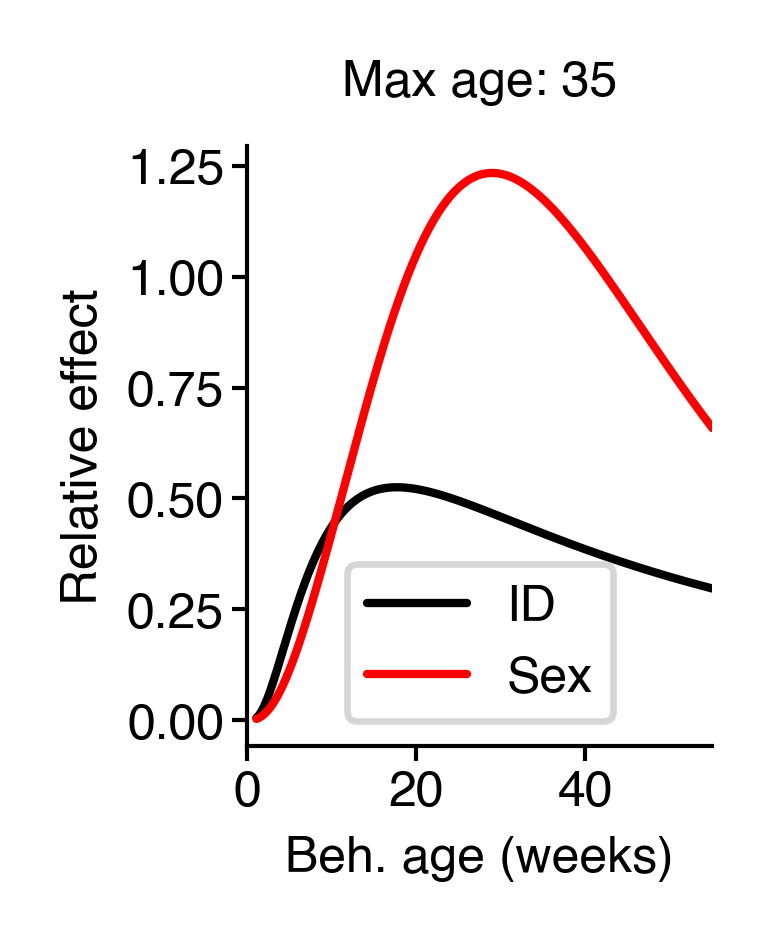

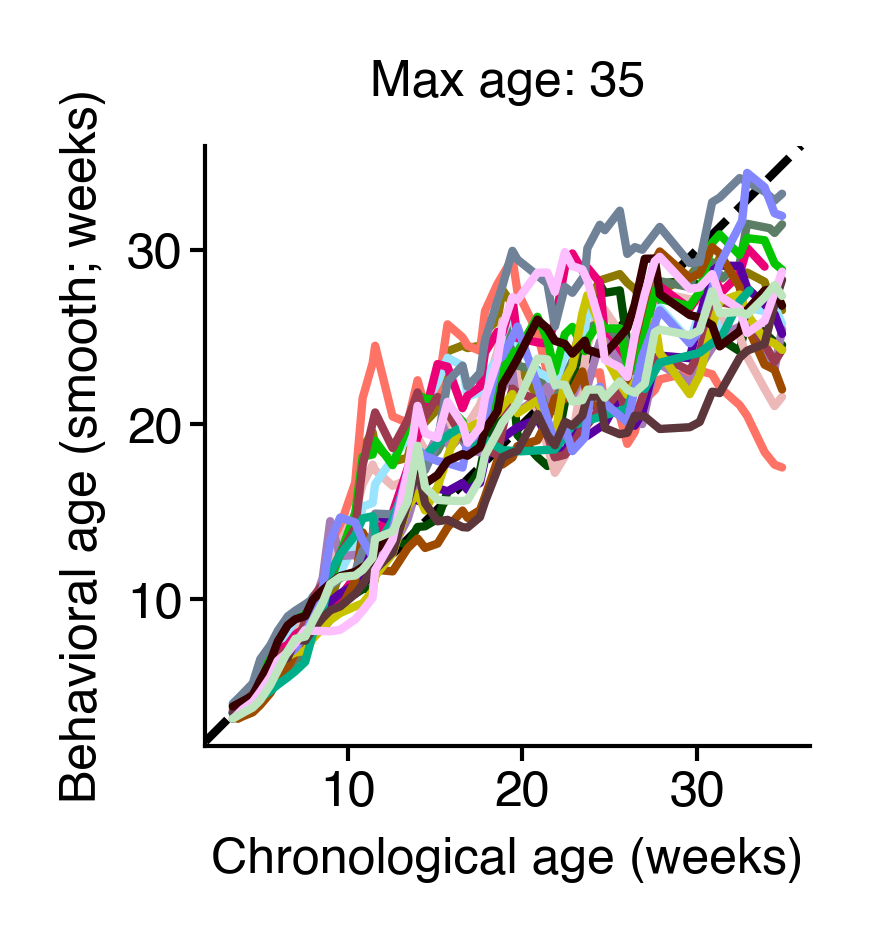

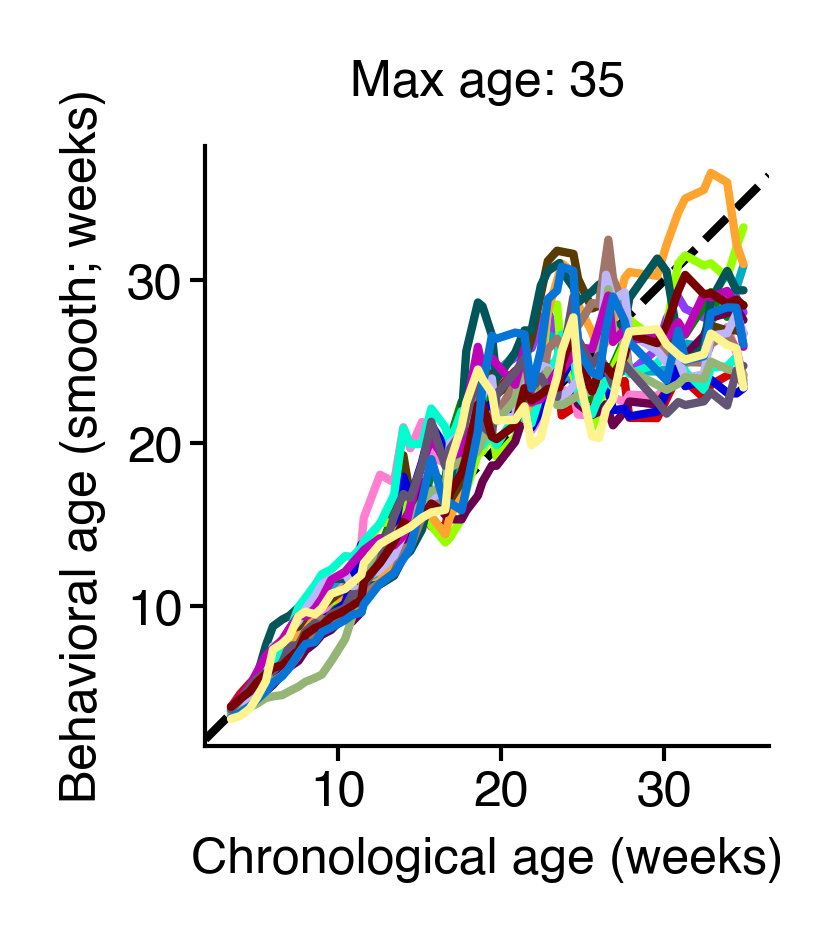

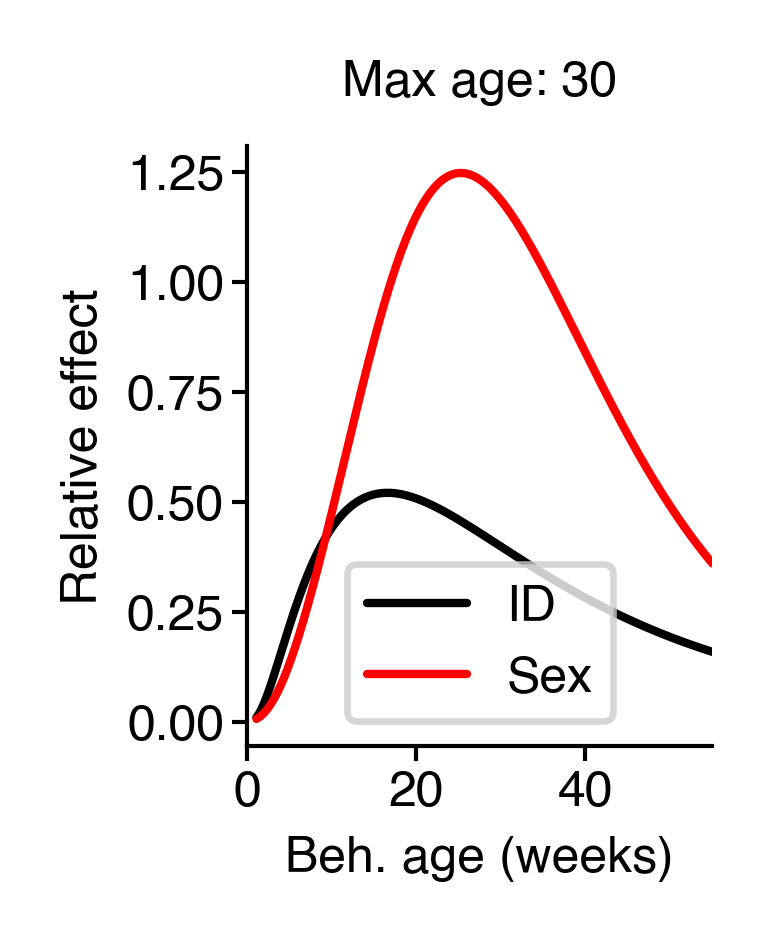

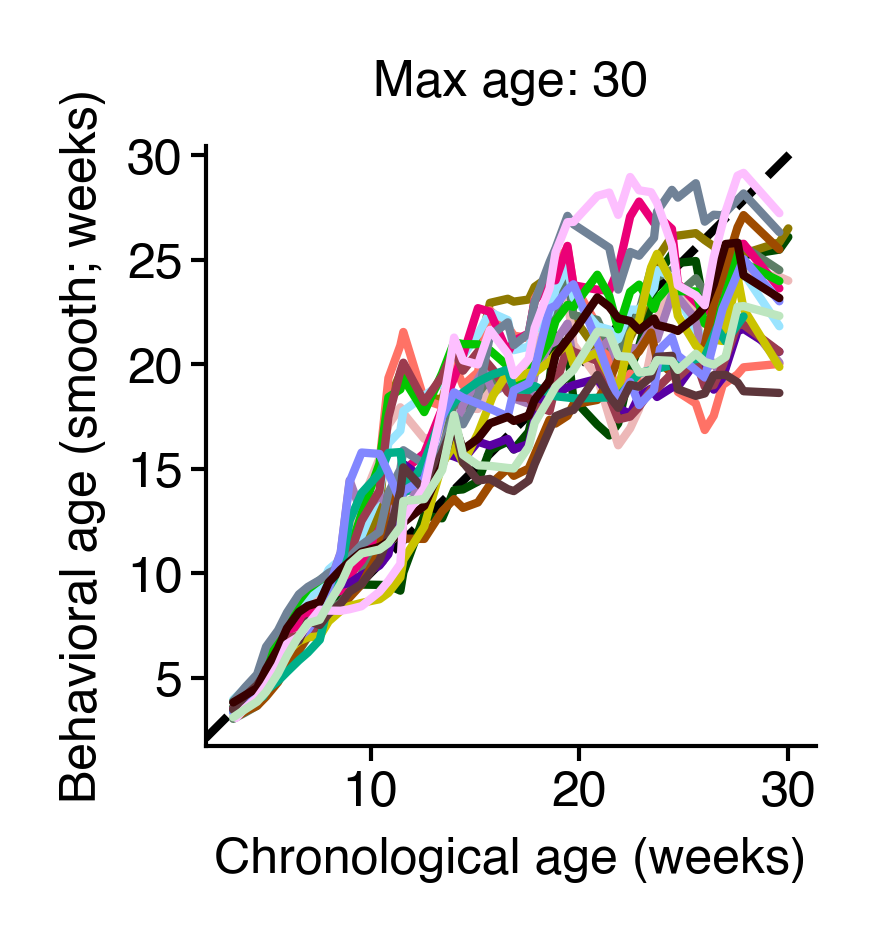

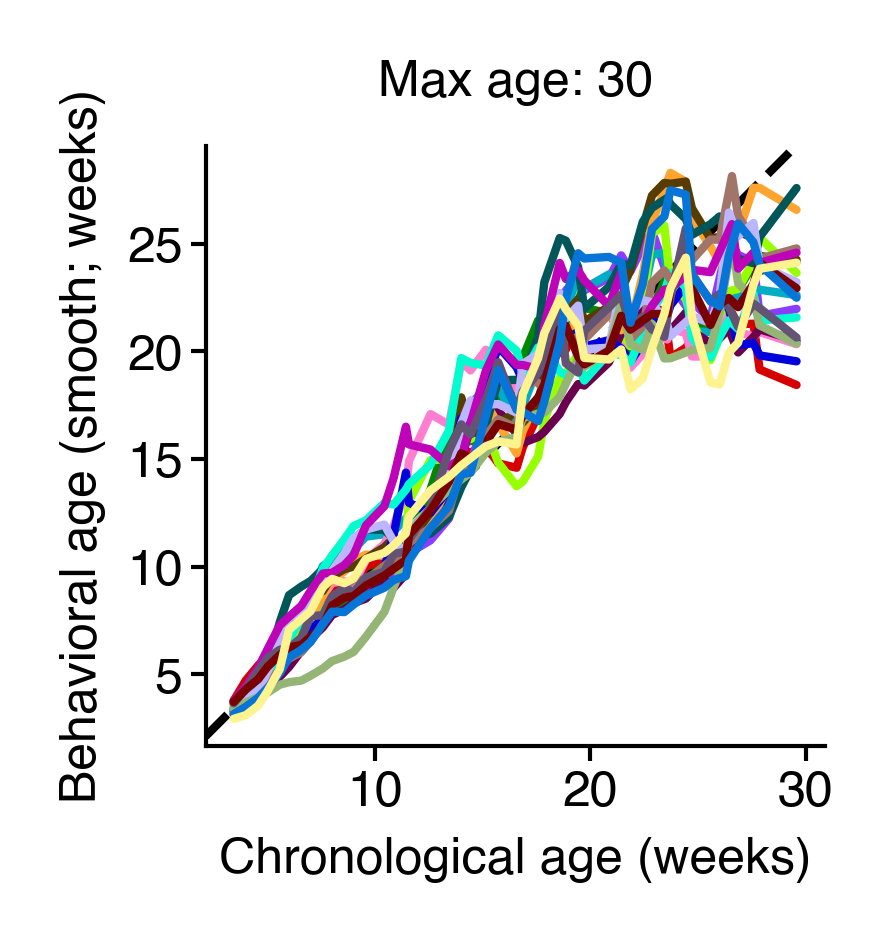

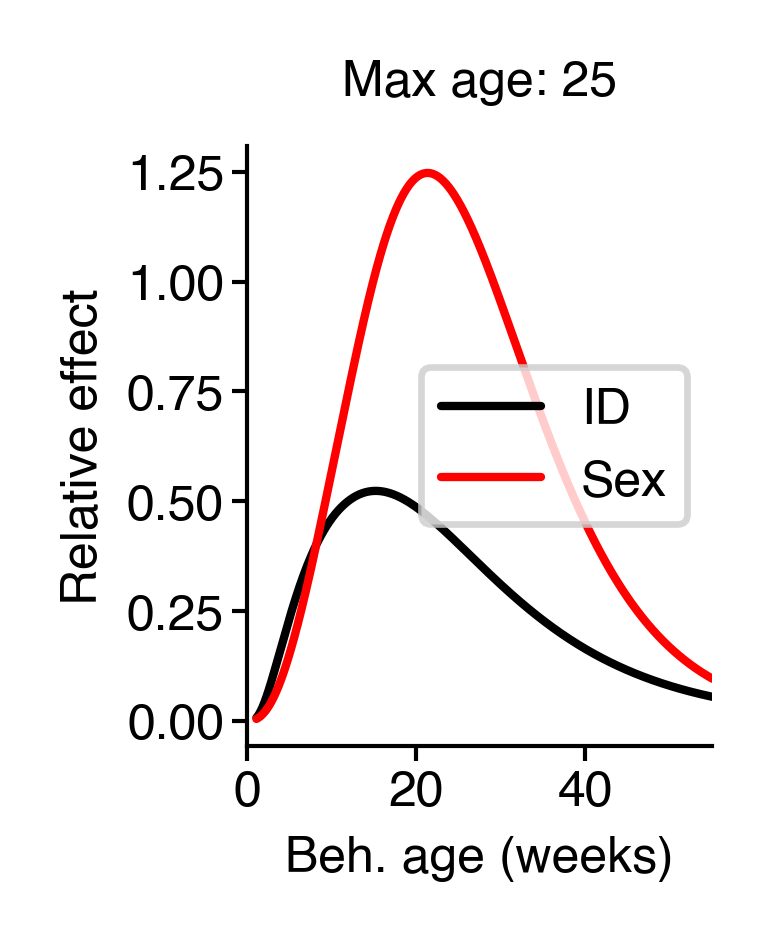

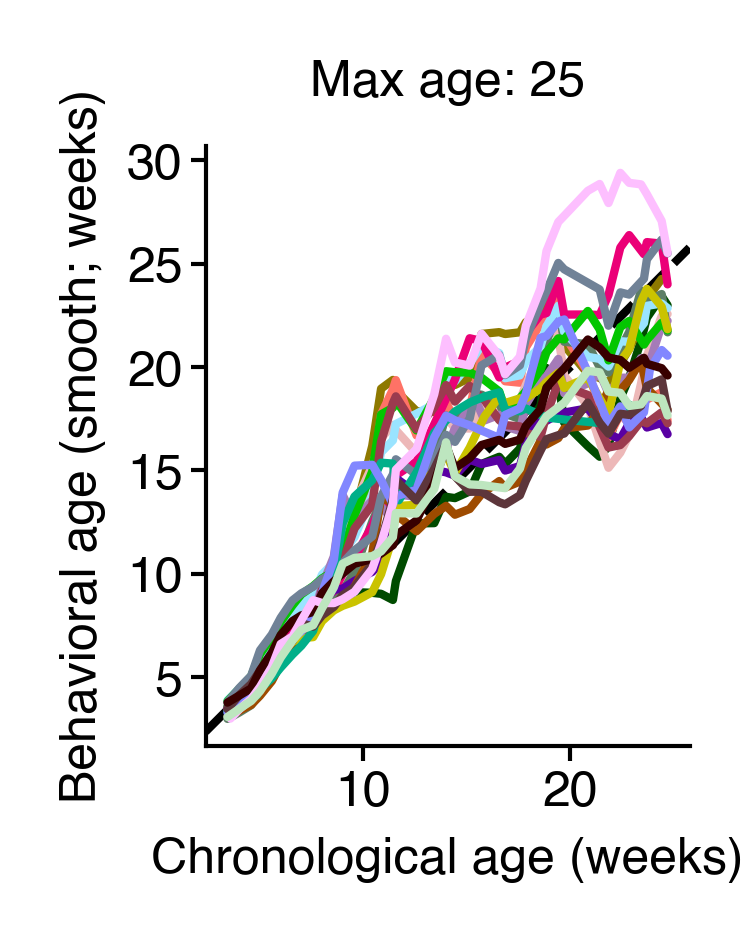

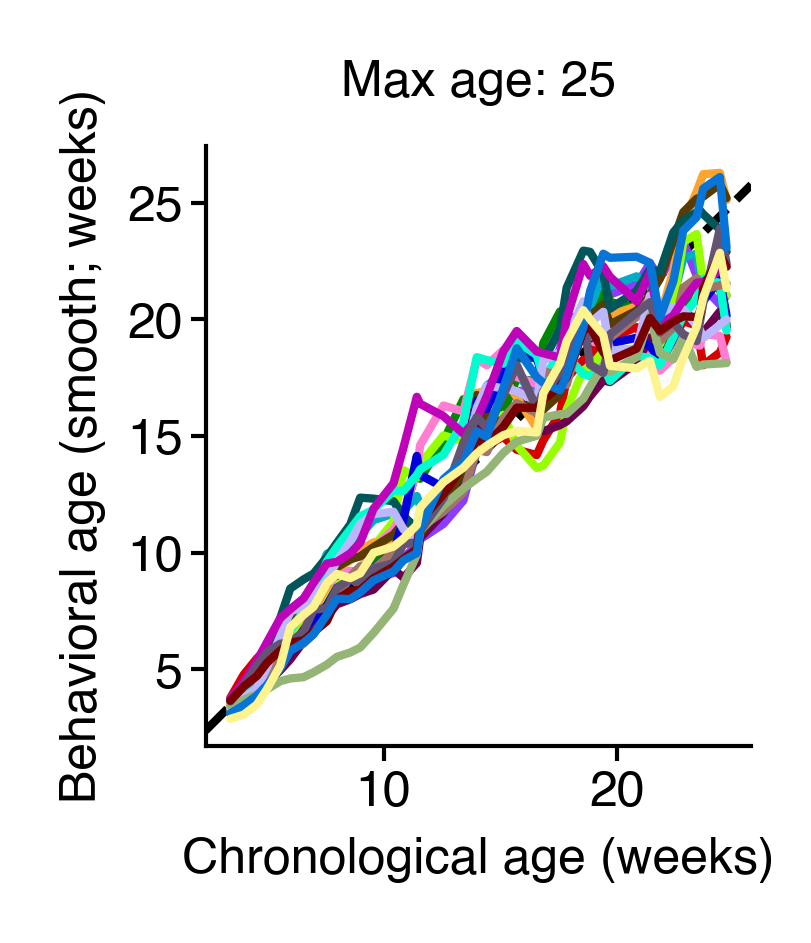

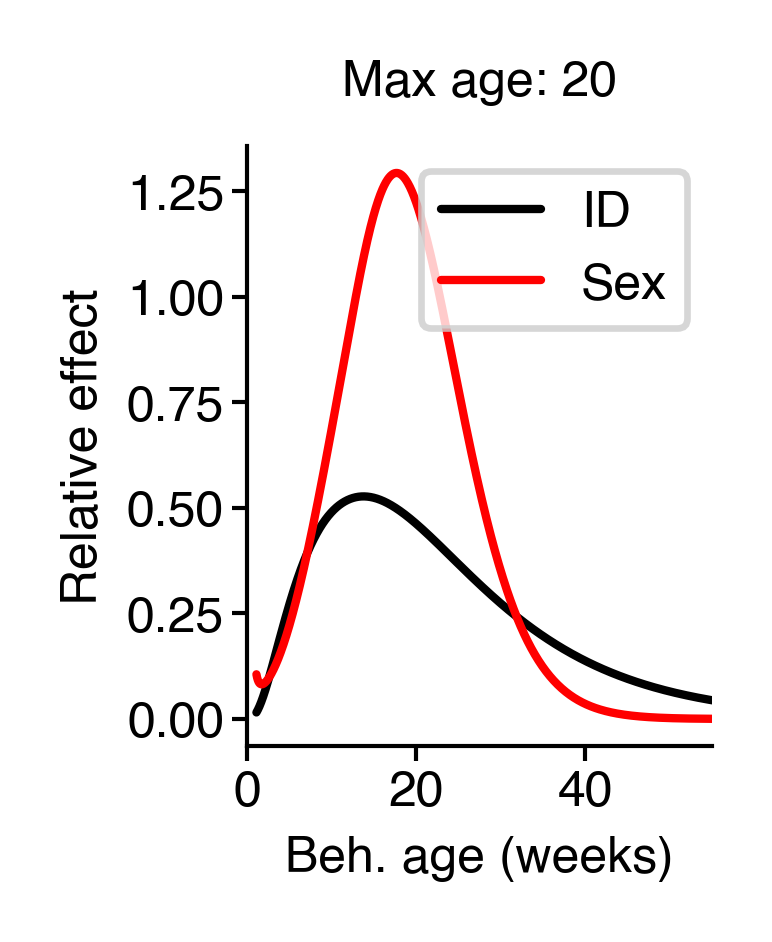

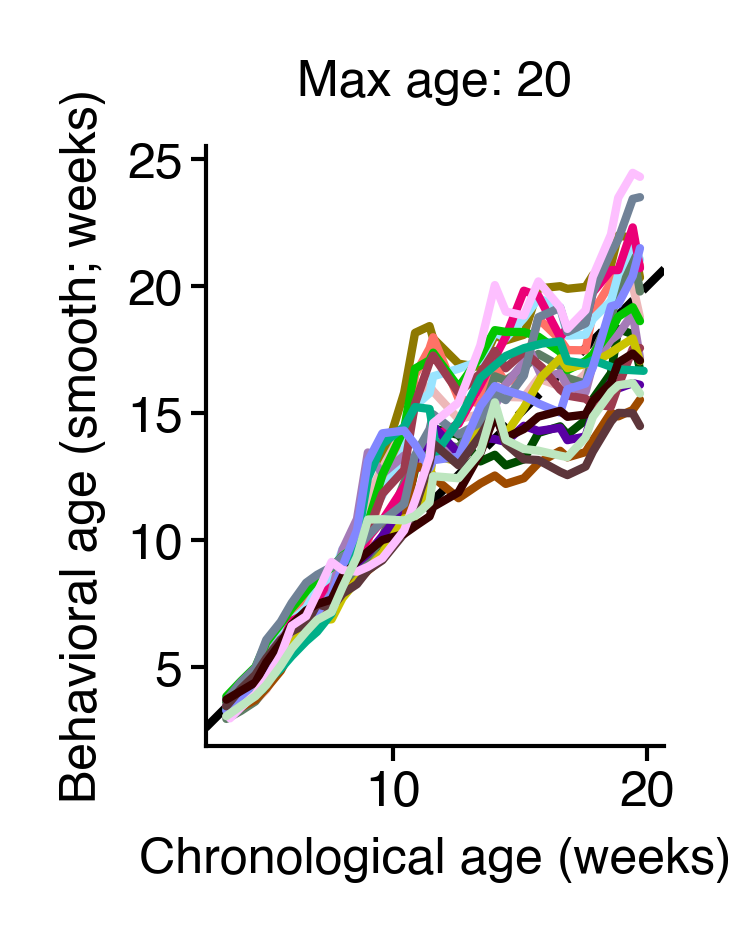

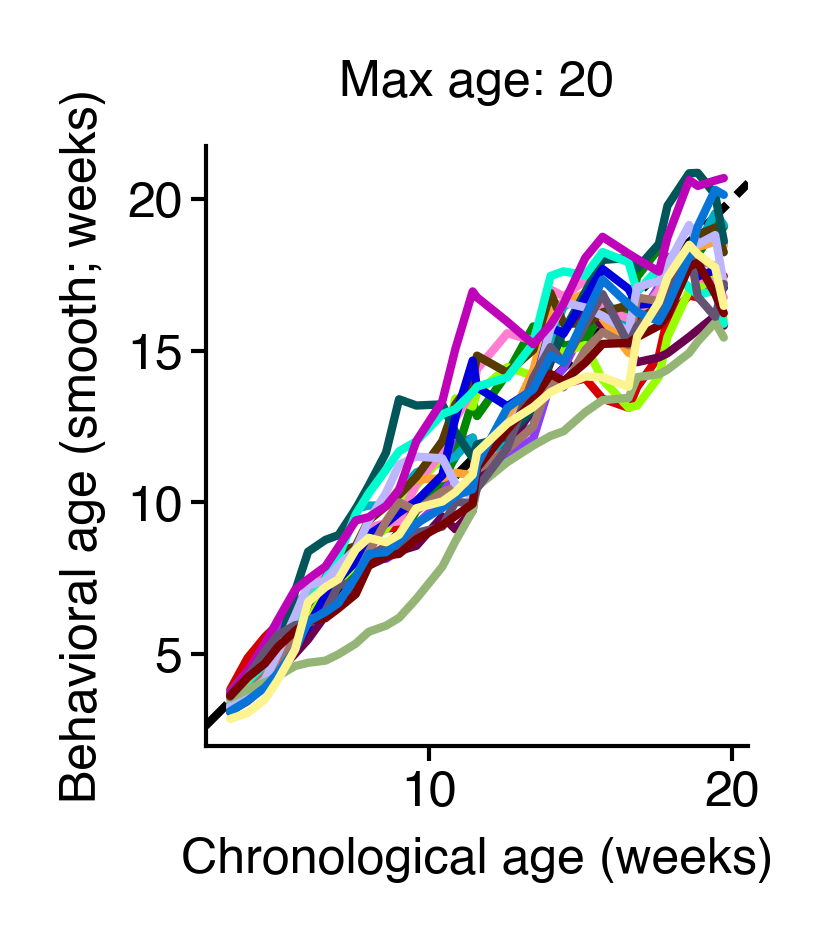

In [ ]:
age_sd = 0.03

for ma in max_age:
    tmp_df = df.query('age <= @ma')

    size_col = tmp_df['quant_0.5']

    tmp_df = tmp_df.drop(columns=['quant_0.5'])

    sort_idx = np.argsort(tmp_df.to_numpy().sum(0))[::-1]

    mask = tmp_df.index.get_level_values('sex') == 0

    sex_id = label_encoder.fit_transform(np.hstack([np.zeros(mask.sum()), np.ones((1 - mask).sum())])[:, None]).T

    mouse_ids = label_encoder.fit_transform(tmp_df.index.get_level_values("mouse").to_numpy()[:, None]).T
    mouse_cat = label_encoder.categories_[0]

    syllable_counts_jax = jnp.array(tmp_df.astype('float32'))
    age = jnp.array(tmp_df.index.get_level_values('age'))

    features = {
        "ages": age,  # models >= 1
        "counts": syllable_counts_jax + 1,  # models >= 1
        "sizes": size_col.to_numpy(),  # models > 1
        "sex": sex_id,
        "mice": mouse_ids,
    }

    hypparams = {
        "log_age": True,
        "min_age": 1,
        "max_age": 130,
        "age_sd": age_sd,
        "n_age_samples": 1500,
        "n_splines": 5,
        "n_syllables": syllable_counts_jax.shape[1],
        "n_development_splines": 5,
        "n_sex_splines": 5,
        "scale": 400,
        "normalize_by_softmax": True,
        "n_keep_sylls": 25,
        "n_sessions": len(syllable_counts_jax),
        "n_animals": len(mouse_ids),
        "n_sexes": len(sex_id),
        "lr": 0.2,
        "n_opt_iter": 900,
    }

    try:
        mdl = fit_model(features, hypparams, 6)
    except ValueError:
        continue

    x = mdl['params']['development_weights']
    dev = (x @ mdl['init_components'].bases['development']).squeeze()
    comps = mdl['init_components']
    dev = np.exp(dev)

    fig = figure(1, 1.3)
    ax = fig.gca()
    _x = comps.age_unnormalizer(comps.age_samples)
    ax.plot(_x[_x < 60], dev[_x < 60], color='k', label="ID")

    x = mdl['params']['sex_weights']
    dev = (x @ mdl['init_components'].bases['sex']).squeeze()
    dev = np.exp(dev)

    ax.plot(_x[_x < 60], dev[_x < 60], color='r', label="Sex")
    plt.xlim(0, 55)
    # plt.ylim(0, 1.2)
    plt.xlabel("Beh. age (weeks)")
    plt.ylabel("Relative effect")
    plt.title(f"Max age: {ma}")
    plt.legend()
    sns.despine()

    age_df = pd.DataFrame(
        dict(bio_ages=mdl["bio_ages"], true_ages=mdl["true_ages"], labels=np.argmax(features['mice'], axis=0),
             # sex=np.argmax(features['sex'], axis=0),
            ),
        index=tmp_df.index
    )
    male = age_df.query('sex==0').copy()
    female = age_df.query('sex==1').copy()

    male["smoothed_bio_age"] = male.groupby("mouse")["bio_ages"].transform(
        lambda x: x.rolling(7, center=True, win_type="exponential", min_periods=1).mean(
            tau=1.25
        )
    )
    female["smoothed_bio_age"] = female.groupby("mouse")["bio_ages"].transform(
        lambda x: x.rolling(7, center=True, win_type="exponential", min_periods=1).mean(
            tau=1.25
        )
    )

    fig = figure(1.5, 1.3)
    ax = sns.lineplot(
        data=male,
        x="true_ages",
        y="smoothed_bio_age",
        hue="labels",
        palette=cc.glasbey[20:40],
        legend=False,
    )
    ax.set(
        aspect="equal",
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (smooth; weeks)",
    )
    add_identity(ax, c="k", ls="--", zorder=-1)
    sns.despine()
    plt.title(f"Max age: {ma}")

    fig = figure(1.5, 1.3)
    ax = sns.lineplot(
        data=female,
        x="true_ages",
        y="smoothed_bio_age",
        hue="labels",
        palette=cc.glasbey[:20],
        legend=False,
    )
    ax.set(
        aspect="equal",
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (smooth; weeks)",
    )
    add_identity(ax, c="k", ls="--", zorder=-1)
    sns.despine()
    plt.title(f"Max age: {ma}")
    plt.show()

### Fit strong prior version of model

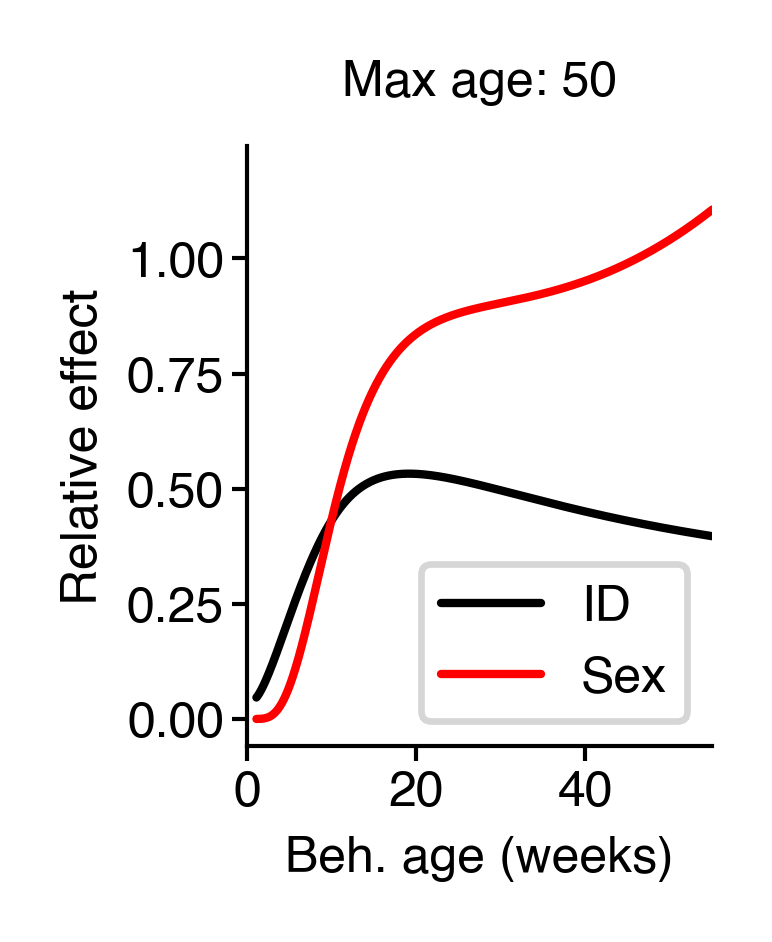

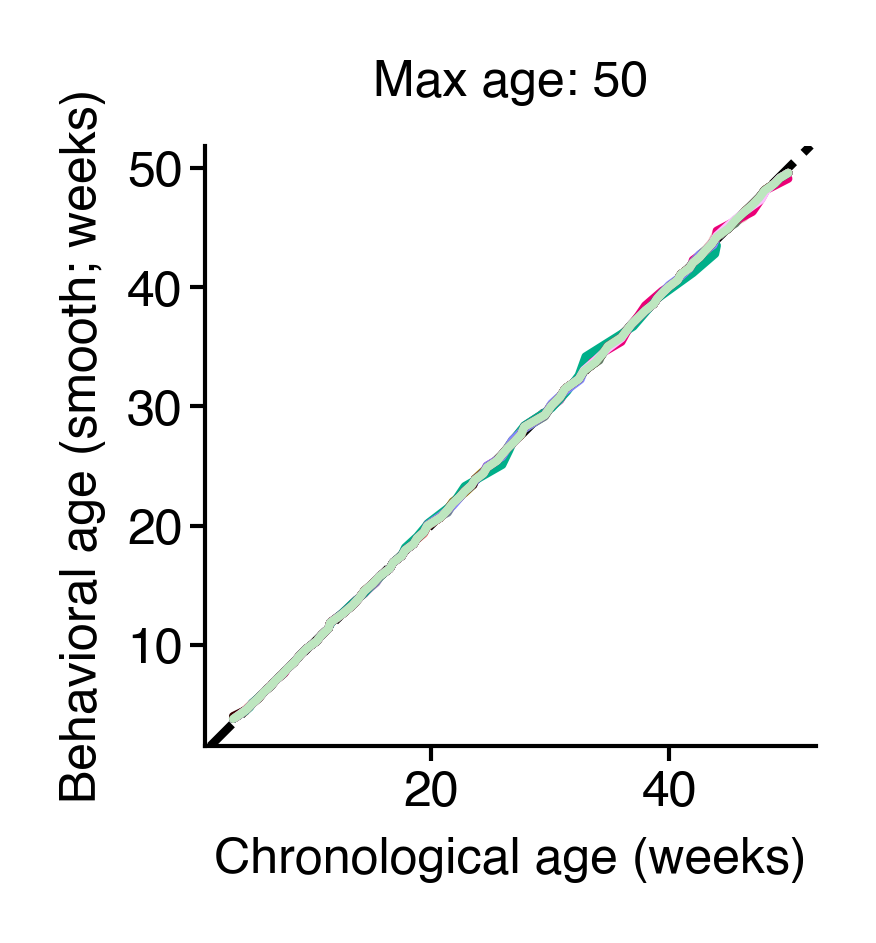

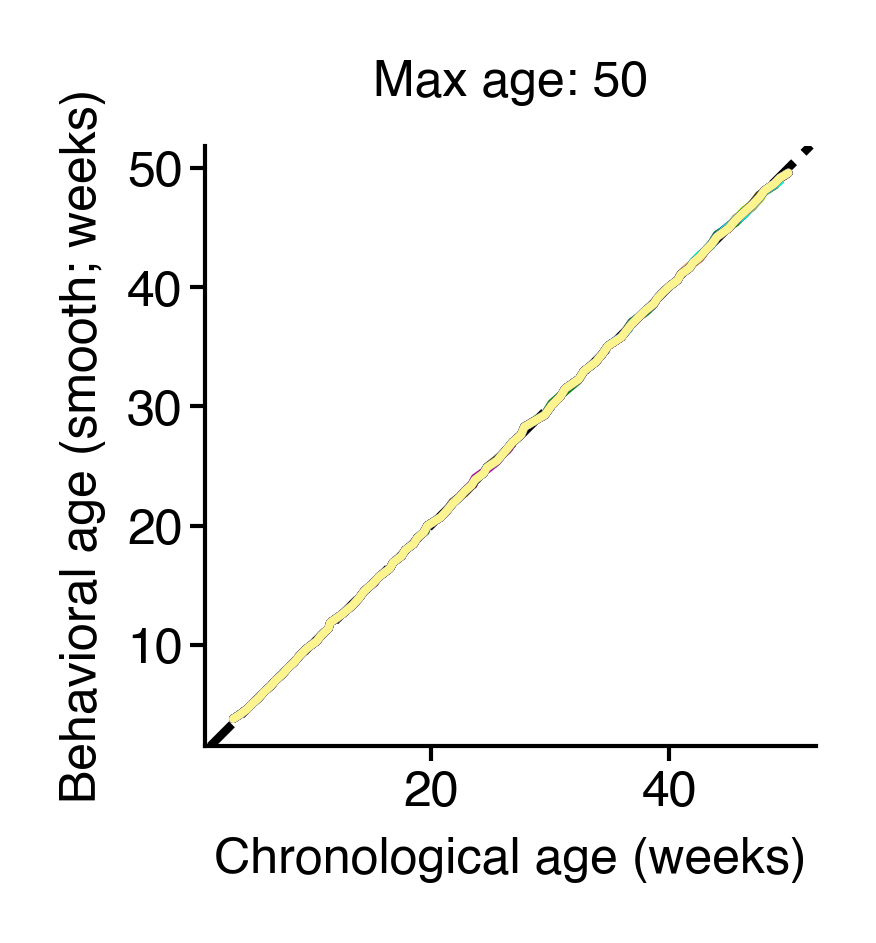

In [15]:
age_sd = 1e-4

for ma in max_age:
    tmp_df = df.query('age <= @ma')

    size_col = tmp_df['quant_0.5']

    tmp_df = tmp_df.drop(columns=['quant_0.5'])

    sort_idx = np.argsort(tmp_df.to_numpy().sum(0))[::-1]

    mask = tmp_df.index.get_level_values('sex') == 0

    sex_id = label_encoder.fit_transform(np.hstack([np.zeros(mask.sum()), np.ones((1 - mask).sum())])[:, None]).T

    mouse_ids = label_encoder.fit_transform(tmp_df.index.get_level_values("mouse").to_numpy()[:, None]).T
    mouse_cat = label_encoder.categories_[0]

    syllable_counts_jax = jnp.array(tmp_df.astype('float32'))
    age = jnp.array(tmp_df.index.get_level_values('age'))

    features = {
        "ages": age,  # models >= 1
        "counts": syllable_counts_jax + 1,  # models >= 1
        "sizes": size_col.to_numpy(),  # models > 1
        "sex": sex_id,
        "mice": mouse_ids,
    }

    hypparams = {
        "log_age": True,
        "min_age": 1,
        "max_age": 130,
        "age_sd": age_sd,
        "n_age_samples": 1500,
        "n_splines": 5,
        "n_syllables": syllable_counts_jax.shape[1],
        "n_development_splines": 5,
        "n_sex_splines": 5,
        "scale": 400,
        "normalize_by_softmax": True,
        "n_keep_sylls": 25,
        "n_sessions": len(syllable_counts_jax),
        "n_animals": len(mouse_ids),
        "n_sexes": len(sex_id),
        "lr": 0.2,
        "n_opt_iter": 900,
    }

    try:
        mdl = fit_model(features, hypparams, 6)
    except ValueError:
        continue

    x = mdl['params']['development_weights']
    dev = (x @ mdl['init_components'].bases['development']).squeeze()
    comps = mdl['init_components']
    dev = np.exp(dev)

    fig = figure(1, 1.3)
    ax = fig.gca()
    _x = comps.age_unnormalizer(comps.age_samples)
    ax.plot(_x[_x < 60], dev[_x < 60], color='k', label="ID")

    x = mdl['params']['sex_weights']
    dev = (x @ mdl['init_components'].bases['sex']).squeeze()
    dev = np.exp(dev)

    ax.plot(_x[_x < 60], dev[_x < 60], color='r', label="Sex")
    plt.xlim(0, 55)
    # plt.ylim(0, 1.2)
    plt.xlabel("Beh. age (weeks)")
    plt.ylabel("Relative effect")
    plt.title(f"Max age: {ma}")
    plt.legend()
    sns.despine()

    age_df = pd.DataFrame(
        dict(bio_ages=mdl["bio_ages"], true_ages=mdl["true_ages"], labels=np.argmax(features['mice'], axis=0),
             # sex=np.argmax(features['sex'], axis=0),
            ),
        index=tmp_df.index
    )
    male = age_df.query('sex==0').copy()
    female = age_df.query('sex==1').copy()

    male["smoothed_bio_age"] = male.groupby("mouse")["bio_ages"].transform(
        lambda x: x.rolling(7, center=True, win_type="exponential", min_periods=1).mean(
            tau=1.25
        )
    )
    female["smoothed_bio_age"] = female.groupby("mouse")["bio_ages"].transform(
        lambda x: x.rolling(7, center=True, win_type="exponential", min_periods=1).mean(
            tau=1.25
        )
    )

    fig = figure(1.5, 1.3)
    ax = sns.lineplot(
        data=male,
        x="true_ages",
        y="smoothed_bio_age",
        hue="labels",
        palette=cc.glasbey[20:40],
        legend=False,
    )
    ax.set(
        aspect="equal",
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (smooth; weeks)",
    )
    add_identity(ax, c="k", ls="--", zorder=-1)
    sns.despine()
    plt.title(f"Max age: {ma}")

    fig = figure(1.5, 1.3)
    ax = sns.lineplot(
        data=female,
        x="true_ages",
        y="smoothed_bio_age",
        hue="labels",
        palette=cc.glasbey[:20],
        legend=False,
    )
    ax.set(
        aspect="equal",
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (smooth; weeks)",
    )
    add_identity(ax, c="k", ls="--", zorder=-1)
    sns.despine()
    plt.title(f"Max age: {ma}")
    plt.show()
    break

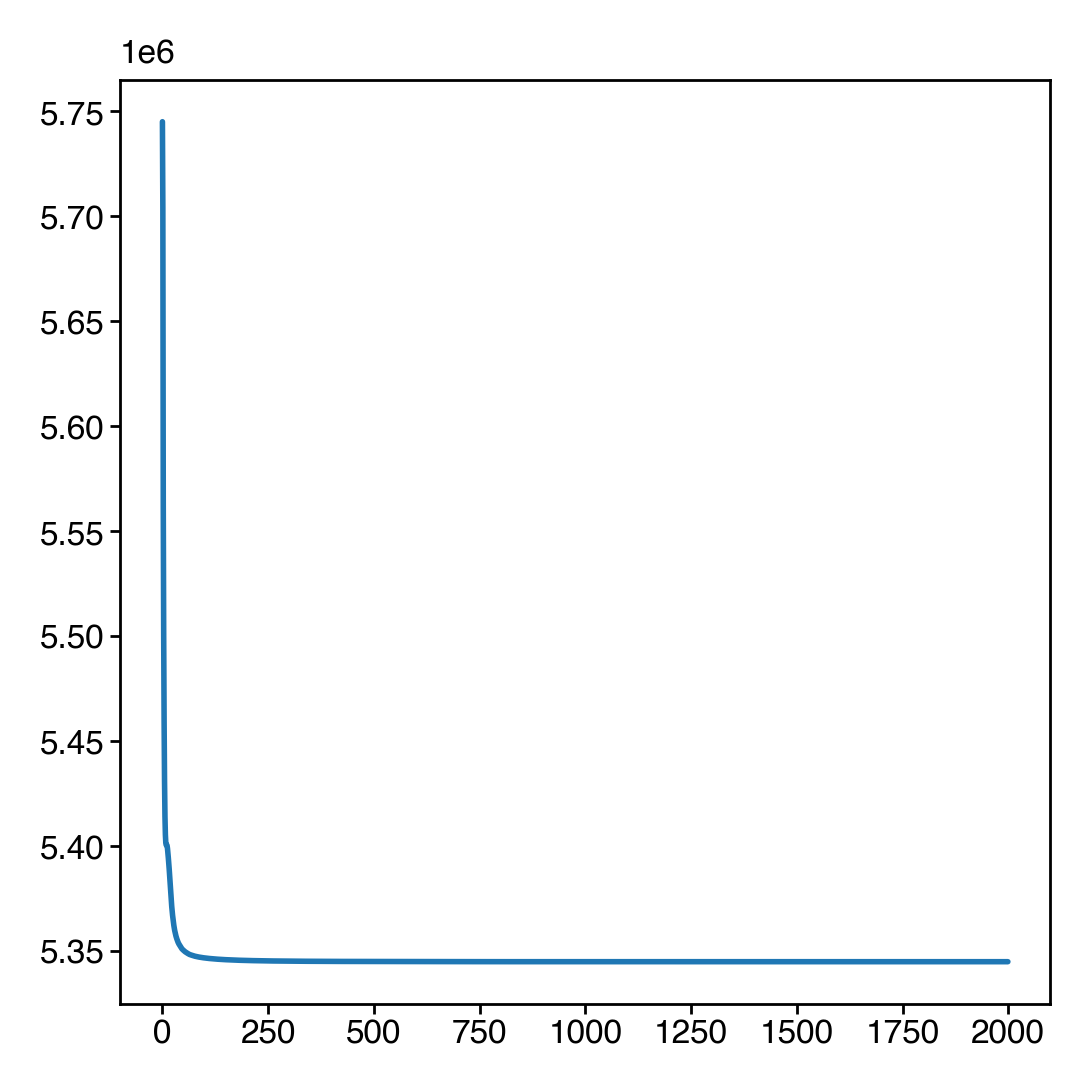

In [16]:
plt.plot(mdl['loss'])